## Imports, API access, and cache directory

In [23]:
import os, json, time, hashlib
import requests
from pathlib import Path

from dotenv import load_dotenv

PROJECT_ROOT = Path.cwd().parent
CACHE_DIR = PROJECT_ROOT / "data_cache"
CACHE_DIR.mkdir(exist_ok=True)

load_dotenv((Path.cwd().parent / ".env"))



True

In [24]:
TOKEN = os.getenv("FOOTBALL_DATA_TOKEN")
if not TOKEN:
    raise ValueError("FOOTBALL_DATA_TOKEN not found")

BASE_URL = "https://api.football-data.org/v4"
HEADERS = {"X-Auth-Token": TOKEN}

print("Project root:", PROJECT_ROOT)
print("Cache dir:", CACHE_DIR)

Project root: c:\Users\aryaa\Desktop\actualproj\epl_predictor
Cache dir: c:\Users\aryaa\Desktop\actualproj\epl_predictor\data_cache


In [25]:
def _make_cache_key(url: str, params: dict | None) -> str:

    p = "" if not params else "&".join(f"{k}={params[k]}" for k in sorted(params))
    raw = f"{url}?{p}"
    return hashlib.md5(raw.encode("utf-8")).hexdigest()

def fetch_json(url: str, params: dict | None = None, ttl_seconds: int = 3600) -> dict:
    """
    Fetch JSON from API with simple disk caching.
    - ttl_seconds: reuse cached response if newer than this.
    """
    cache_key = _make_cache_key(url, params)
    cache_file = CACHE_DIR / f"{cache_key}.json"

    if cache_file.exists():
        age = time.time() - cache_file.stat().st_mtime
        if age < ttl_seconds:
            with open(cache_file, "r", encoding="utf-8") as f:
                return json.load(f)
    
    r = requests.get(url, headers=HEADERS, params=params, timeout=30)
    if r.status_code != 200:
        raise RuntimeError(f"API error {r.status_code}: {r.text[:300]}")

    data = r.json()

    # Save cache
    with open(cache_file, "w", encoding="utf-8") as f:
        json.dump(data, f)

    return data

### Testing API Access

##### "Status: 200" and visible data means we are good to go

In [27]:
matches_url = f"{BASE_URL}/competitions/PL/matches"

r = requests.get(matches_url, headers=HEADERS, timeout=30)
print("status:", r.status_code)
print("first 200 chars:", r.text[:200])
r.raise_for_status()

data = r.json()
print("matches returned:", len(data.get("matches", [])))


status: 200
first 200 chars: {"filters":{"season":"2025"},"resultSet":{"count":380,"first":"2025-08-15","last":"2026-05-24","played":250},"competition":{"id":2021,"name":"Premier League","code":"PL","type":"LEAGUE","emblem":"http
matches returned: 380


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

rows = []

for match in data["matches"]:
    rows.append({
        'match_id' : match["id"],
        'utc_date' : match["utcDate"],
        'status' : match["status"],
        'matchday' : match["matchday"],
        'home_team' : match["homeTeam"]["name"],
        'away_team' : match["awayTeam"]["name"],
        'winning_team' : match["score"]["winner"],
        'half_time_score_home' : match["score"]["halfTime"]["home"],
        'half_time_score_away' : match["score"]["halfTime"]["away"],
        'full_time_score_home' : match["score"]["fullTime"]["home"],
        'full_time_score_away' : match["score"]["fullTime"]["away"]
    })

teams = {}
for match in data.get("matches", []):
    for side in ["homeTeam", "awayTeam"]:
        t = match.get(side) or {}
        team_id = t.get("id")
        if team_id is None:
            continue

        teams[team_id] = {
            "team_id": team_id,
            "team_shortname": t.get("shortName") or t.get("name"),
            "team_tla": t.get("tla"),
        }

matches_df = pd.DataFrame(rows)
matches_df["utc_date"] = pd.to_datetime(matches_df["utc_date"], utc=True)

teams_df = pd.DataFrame(list(teams.values())).sort_values("team_shortname")

teams_df = (
    pd.DataFrame(list(teams.values()))
      .sort_values("team_shortname")
      .reset_index(drop=True)
)

#print(matches_df.head())
print(teams_df.head())

   team_id team_shortname team_tla
0       57        Arsenal      ARS
1       58    Aston Villa      AVL
2     1044    Bournemouth      BOU
3      402      Brentford      BRE
4      397  Brighton Hove      BHA


#### Quick visualization of Total Goals per Match so far

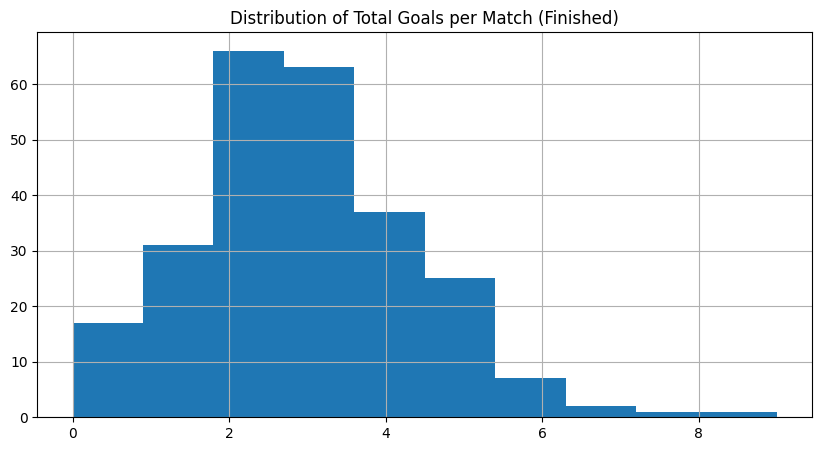

,team_id,team_shortname,team_tla
0,57,Arsenal,ARS
1,58,Aston Villa,AVL
2,1044,Bournemouth,BOU
3,402,Brentford,BRE
4,397,Brighton Hove,BHA
5,328,Burnley,BUR
6,61,Chelsea,CHE
7,354,Crystal Palace,CRY
8,62,Everton,EVE
9,63,Fulham,FUL


In [47]:
finished = matches_df[matches_df["status"] == "FINISHED"].copy()
finished["total_goals"] = finished["full_time_score_home"].fillna(0) + finished["full_time_score_away"].fillna(0)

plt.figure(figsize=(10, 5))
finished["total_goals"].hist(bins=10)
plt.title("Distribution of Total Goals per Match (Finished)")
plt.show()

display(teams_df)


### Loading data into SQL with DuckDB

In [48]:
import duckdb

con = duckdb.connect("epl.duckdb")

con.execute("CREATE OR REPLACE TABLE teams AS SELECT * FROM teams_df")
con.execute("CREATE OR REPLACE TABLE matches AS SELECT * FROM matches_df")

#### Some interesting tables to provide insight

In [ ]:
duckdb.sql("CREATE TABLE ")

┌─────────┬────────────────┬──────────┐
│ team_id │ team_shortname │ team_tla │
│  int64  │    varchar     │ varchar  │
├─────────┼────────────────┼──────────┤
│      57 │ Arsenal        │ ARS      │
│      58 │ Aston Villa    │ AVL      │
│    1044 │ Bournemouth    │ BOU      │
│     402 │ Brentford      │ BRE      │
│     397 │ Brighton Hove  │ BHA      │
│     328 │ Burnley        │ BUR      │
│      61 │ Chelsea        │ CHE      │
│     354 │ Crystal Palace │ CRY      │
│      62 │ Everton        │ EVE      │
│      63 │ Fulham         │ FUL      │
│     341 │ Leeds United   │ LEE      │
│      64 │ Liverpool      │ LIV      │
│      65 │ Man City       │ MCI      │
│      66 │ Man United     │ MUN      │
│      67 │ Newcastle      │ NEW      │
│     351 │ Nottingham     │ NOT      │
│      71 │ Sunderland     │ SUN      │
│      73 │ Tottenham      │ TOT      │
│     563 │ West Ham       │ WHU      │
│      76 │ Wolverhampton  │ WOL      │
├─────────┴────────────────┴──────────┤
